# Setup


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



# Mount google drive and load dataset

In [ ]:
  from google.colab import drive

  drive.mount('/content/drive')
  

Mounted at /content/drive


Converting .tif to .jpg

In [ ]:
import os
from PIL import Image

def convert_images(path_to_data_folder, path_to_save_folder):
  #Each class must recide in its own folder.
  #Returns data as (image as nparray, class)
  #gathering classes
  class_titles = os.listdir(path_to_data_folder)
  classes_list = list( ( enumerate( class_titles ) ) )
  ordered_image_names = []
  #placing image, class identifier (from classes_list) pairs in a list named data
  data = []
  number_of_images = 0
  errors = 0 
  for gyro_class in classes_list:
    os.mkdir(os.path.join(path_to_save_folder,gyro_class[1]))
    for image_name in os.listdir( os.path.join( path_to_data_folder, gyro_class[1] ) ):
      number_of_images+=1
      try:
        im = Image.open( os.path.join( path_to_data_folder, gyro_class[1] , image_name)  )
        print("Generating jpeg for %s" % image_name)
        savepath = os.path.join(path_to_save_folder, gyro_class[1] , os.path.splitext(image_name)[0]+ ".jpg")
        im.save(savepath, "JPEG", quality=100)

      except Exception as error :
        errors+=1
        print( error, image_name)


In [ ]:
#save_folder = "/content/drive/MyDrive/jpegData"

#convert_images("/content/drive/MyDrive/ML for food authentication/Data", save_folder)

# Preparing dataset

In [ ]:
image_size = (256, 341)
batch_size=10
num_of_classes=3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/jpegData/"+str(num_of_classes)+" classes",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

np_dataset = list(dataset.as_numpy_iterator())

labels=[]
images=[]
for batch in np_dataset:
  batch_images, batch_labels = batch
  for i in range(len(batch_labels)):
    labels.append(batch_labels[i])
    images.append(batch_images[i])

Found 311 files belonging to 3 classes.


# Image and class

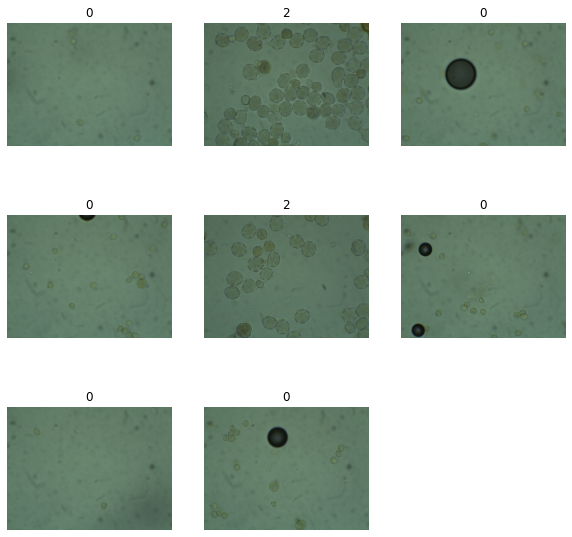

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


# Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        #layers.experimental.preprocessing.RandomCrop(int(image_size[0]/2.5), int(image_size[1]/2.5))
    ]
)


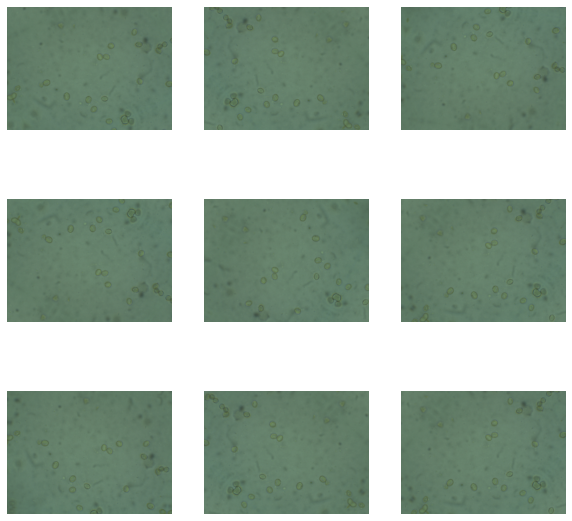

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
#plt.savefig("augmented_images.png")

<Figure size 432x288 with 0 Axes>

# Training


In [ ]:
def make_model(input_shape, num_classes):

  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  #x = data_augmentation(inputs)


  x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(5, kernel_size=(3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(5, kernel_size=(3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(num_classes, activation="softmax")(x)

  return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
#keras.utils.plot_model(model, show_shapes=True)


In [ ]:
from sklearn.model_selection import train_test_split

model.compile(
#    optimizer=keras.optimizers.RMSprop(1e-3),
#    optimizer=keras.optimizers.SGD(lr=1e-3, nesterov=True),
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)

X_train, X_test, y_train, y_test = train_test_split(
np.asarray(images), np.asarray(labels), test_size=0.33, random_state=42)




In [ ]:
history = model.fit(
    x=X_train, y=y_train, callbacks=[callback], validation_data=(X_test, y_test),epochs=180, batch_size=8)

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()


In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()


# Grid Search

Splitting Images and labels

In [ ]:
from sklearn.model_selection import train_test_split


image_size = (256, 341)
batch_size=10
num_of_classes=3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/jpegData/"+str(num_of_classes)+" classes",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

np_dataset = list(dataset.as_numpy_iterator())

labels=[]
images=[]
for batch in np_dataset:
  batch_images, batch_labels = batch
  for i in range(len(batch_labels)):
    labels.append(batch_labels[i])
    images.append(batch_images[i])

X_train, X_test, y_train, y_test = train_test_split(
np.asarray(images), np.asarray(labels), test_size=0.33, random_state=42)


Found 311 files belonging to 3 classes.


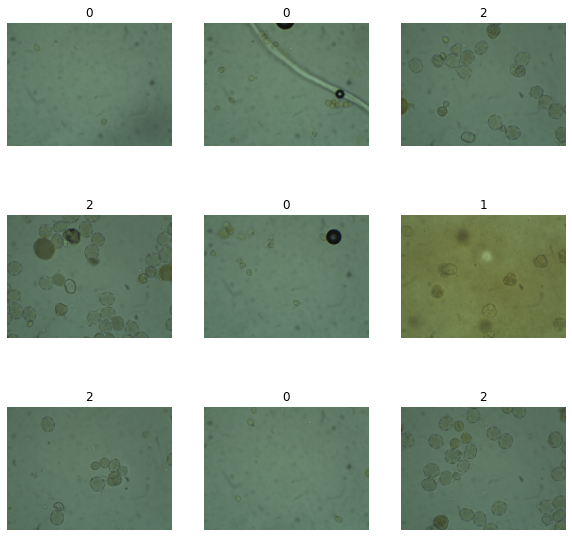

In [ ]:
plt.figure(figsize=(10, 10))
i=0
for j in range(len(images)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[j].astype("uint8"))
  plt.title(int(labels[j]))
  plt.axis("off")
  i+=1
  if i>8: break



In [ ]:
def make_model(data_augmentation, layer_info):

  inputs = keras.Input(shape=(256, 341)+ (3,))
  
  # Image augmentation block
  augmentation_layer = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
    ]
  )

  if data_augmentation == True:
    x = augmentation_layer(inputs)
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
  else:
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)

  for filters, kernel_size in layer_info:
    x = layers.Conv2D(filters, kernel_size=kernel_size, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(num_of_classes, activation="softmax")(x)

  model = keras.Model(inputs, outputs)

  model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
    )
  return model


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


model = KerasClassifier(build_fn=make_model, verbose=0)

layers_list = [
          [(5,(3,3)), (5,(3,3))],
          [(5,(3,3)), (5,(3,3)), (5,(3,3))],
          [(5,(3,3)), (5,(3,3)), (5,(3,3)), (5,(3,3))],
          [(5,(3,3)), (5,(3,3)), (5,(3,3)), (5,(3,3)), (5,(3,3))]
        ]
augmentation=[True,False]
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=20)
batch_sizes = [8, 16, 32, 64]
param_grid = dict(data_augmentation=augmentation, epochs=[200], layer_info=layers_list, batch_size=batch_sizes, callbacks=[callback])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1, verbose=1)
grid_result = grid.fit(np.asarray(X_train), y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 32.5min finished


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 1.000000 using {'batch_size': 8, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fa9f1673450>, 'data_augmentation': False, 'epochs': 200, 'layer_info': [(5, (3, 3)), (5, (3, 3))]}
0.859903 (0.198127) with: {'batch_size': 8, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fa9f1673450>, 'data_augmentation': True, 'epochs': 200, 'layer_info': [(5, (3, 3)), (5, (3, 3))]}
0.927950 (0.011330) with: {'batch_size': 8, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fa9f1673450>, 'data_augmentation': True, 'epochs': 200, 'layer_info': [(5, (3, 3)), (5, (3, 3)), (5, (3, 3))]}
0.947067 (0.024716) with: {'batch_size': 8, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fa9f1673450>, 'data_augmentation': True, 'epochs': 200, 'layer_info': [(5, (3, 3)), (5, (3, 3)), (5, (3, 3)), (5, (3, 3))]}
0.766529 (0.309683) with: {'batch_size': 8, 'callbacks': <keras.callbacks.EarlyStopping object at 0x7fa9f1673450>, 'data_augmentation': True, 'epochs': 200, 'layer_info'

In [ ]:
import pickle

dictionary_data = grid_result.cv_results_


a_file = open("2_classes_all.pkl", "wb")

pickle.dump(dictionary_data, a_file)

a_file.close()


a_file = open("2_classes_all.pkl", "rb")

output = pickle.load(a_file)

print(output)

{'mean_fit_time': array([32.33492009, 18.62200848, 21.71226398, 18.23876301,  7.04749115,
        8.41242901, 12.86742075, 16.14439432, 18.39952501, 23.24015204,
       16.30589263, 26.85629654,  6.39545782,  9.73276043, 12.13825178,
       18.23818405, 17.46755314, 15.61245751, 18.79613455, 15.24304597,
        7.40302579, 12.37427886, 12.59388145, 13.94548066, 16.74952857,
       14.0927097 , 17.1006732 , 24.96785482,  9.93012555, 12.43746003,
       13.50943065, 11.50974003]), 'std_fit_time': array([12.81568584,  1.94361692,  3.64389593,  7.13744434,  0.83440659,
        0.31170919,  0.95411545,  6.08229781,  6.12291711,  5.6494886 ,
        1.77915001,  4.78387017,  0.70649585,  0.79498292,  2.23771527,
        1.86089443,  2.62026196,  1.86945999,  6.52874665,  9.43140966,
        0.44917059,  2.13605919,  1.22308057,  5.47635379,  0.1956528 ,
        4.19935997,  5.87146621,  4.5285493 ,  2.99614222,  1.70341666,
        2.48239684,  7.21495004]), 'mean_score_time': array([15.450

# Aggregating results

In [ ]:
import pickle

a_file = open("2_classes_all.pkl", "rb")

all_dict = pickle.load(a_file)



In [ ]:
for run, i in zip( all_dict["param_layer_info"], range(len(all_dict["param_layer_info"]))):
  all_dict["param_layer_info"][i] = len(all_dict["param_layer_info"][i])


In [ ]:
import pandas as pd

all_df = pd.DataFrame.from_dict(all_dict)
all_df = all_df[["mean_test_score", "std_test_score", "param_batch_size", "param_layer_info", "param_data_augmentation"]]

all_df.rename(columns={"param_layer_info": "depth"}, inplace=True)


In [ ]:
all_df.sort_values("mean_test_score", inplace=True, ascending=False)
all_df.set_index("mean_test_score", drop=True, inplace=True)

In [ ]:
all_df

,std_test_score,param_batch_size,depth,param_data_augmentation
mean_test_score,,,,
1.000000,0.000000,8,2,False
0.995238,0.006734,16,2,False
0.995169,0.006832,32,4,False
0.995169,0.006832,32,2,False
0.980814,0.013567,32,4,True
0.976052,0.017855,8,3,False
0.966322,0.018114,32,2,True
0.961560,0.018023,32,3,False
0.961422,0.018168,8,5,False


In [ ]:
print(all_df.head(10).to_latex(float_format="%.4f", index=True))

\begin{tabular}{lrlll}
\toprule
{} &  std\_test\_score & param\_batch\_size & depth & param\_data\_augmentation \\
mean\_test\_score &                 &                  &       &                         \\
\midrule
1.000000        &          0.0000 &                8 &     2 &                   False \\
0.995238        &          0.0067 &               16 &     2 &                   False \\
0.995169        &          0.0068 &               32 &     4 &                   False \\
0.995169        &          0.0068 &               32 &     2 &                   False \\
0.980814        &          0.0136 &               32 &     4 &                    True \\
0.976052        &          0.0179 &                8 &     3 &                   False \\
0.966322        &          0.0181 &               32 &     2 &                    True \\
0.961560        &          0.0180 &               32 &     3 &                   False \\
0.961422        &          0.0182 &                8 &     5 &  

# Repeated K-fold evaluation of winning architecture

In [ ]:
def make_model():
  num_classes=3
  input_shape=image_size + (3,)
  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  #x = data_augmentation(inputs)


  x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(5, kernel_size=(3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(5, kernel_size=(3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(num_classes, activation="softmax")(x)

  model = keras.Model(inputs, outputs)

  model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
    )

  return model


In [ ]:
from sklearn.model_selection import cross_val_score

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=20, restore_best_weights=False)


model = KerasClassifier(build_fn=make_model, verbose=0)

fit_params=dict(epochs=180, batch_size=8, callbacks=[callback])

results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation of Mean Accuracy"])


for i in range(100):
  scores = cross_val_score(model, np.asarray(images), labels, cv=3, fit_params=fit_params, n_jobs=1)
  results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation of Mean Accuracy":[scores.std()]}), ignore_index=True)
print("Mean Accuracy", results.describe()["Mean Accuracy"].iloc[1])
print("Standard Deviation of Mean Accuracy", results.describe()["Standard Deviation of Mean Accuracy"].iloc[1])

Mean Accuracy 0.9833961941798526
Standard Deviation of Mean Accuracy 0.01714366584139188


In [ ]:
results

,Mean Accuracy,Standard Deviation of Mean Accuracy
0,0.996795,0.004533
1,0.987117,0.009110
2,0.980738,0.020757
3,0.996795,0.004533
4,0.990385,0.013598
...,...,...
95,0.993590,0.009065
96,0.987179,0.018131
97,0.996795,0.004533
98,0.983974,0.022664


# Confusion matrix and other metrics

In [ ]:
#from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
    plt.savefig("confusion_matrix.jpg", dpi=400)

In [ ]:
def make_model(input_shape, num_classes):

  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  #x = data_augmentation(inputs)


  x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(5, kernel_size=(3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(5, kernel_size=(3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(num_classes, activation="softmax")(x)

  return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
#keras.utils.plot_model(model, show_shapes=True)


In [ ]:
from sklearn.model_selection import train_test_split

model.compile(
#    optimizer=keras.optimizers.RMSprop(1e-3),
#    optimizer=keras.optimizers.SGD(lr=1e-3, nesterov=True),
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)

X_train, X_test, y_train, y_test = train_test_split(
np.asarray(images), np.asarray(labels), test_size=0.33, random_state=42)




In [ ]:
history = model.fit(
    x=X_train, y=y_train, callbacks=[callback], validation_data=(X_test, y_test),epochs=200, batch_size=8)

Epoch 1/200
26/26 [==============================] - 1s 24ms/step - loss: 0.3721 - accuracy: 0.8462 - val_loss: 0.3921 - val_accuracy: 0.7767
Epoch 2/200
26/26 [==============================] - 0s 18ms/step - loss: 0.2702 - accuracy: 0.9327 - val_loss: 0.3350 - val_accuracy: 0.8058
Epoch 3/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1653 - accuracy: 0.9663 - val_loss: 0.3762 - val_accuracy: 0.7670
Epoch 4/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1835 - accuracy: 0.9375 - val_loss: 0.5361 - val_accuracy: 0.7184
Epoch 5/200
26/26 [==============================] - 0s 18ms/step - loss: 0.4300 - accuracy: 0.7356 - val_loss: 0.4343 - val_accuracy: 0.7087
Epoch 6/200
26/26 [==============================] - 0s 18ms/step - loss: 0.2088 - accuracy: 0.9423 - val_loss: 0.1389 - val_accuracy: 0.9903
Epoch 7/200
26/26 [==============================] - 0s 18ms/step - loss: 0.1273 - accuracy: 0.9760 - val_loss: 0.1859 - val_accuracy: 0.9126
Epoch 

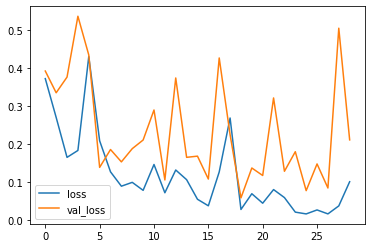

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()


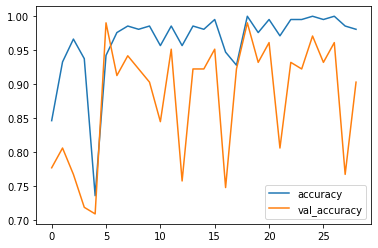

In [ ]:
plt.figure()
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()


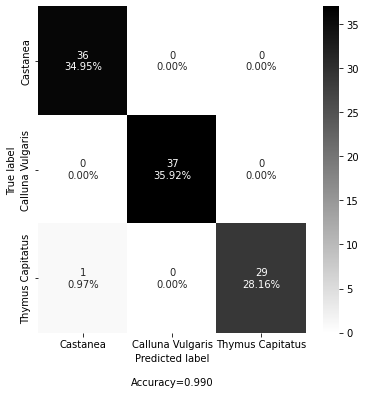

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = np.argmax(model.predict(X_test), axis=1)
cf_matrix = confusion_matrix(y_test, predictions)

labels = ['True Neg',"False Pos","False Neg","True Pos"]
categories = ["Castanea", "Calluna Vulgaris", "Thymus Capitatus"]
make_confusion_matrix(cf_matrix, 
                      figsize=(6,6),
                      group_names=labels,
                      categories=categories, 
                      cmap="binary")


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.97297   1.00000   0.98630        36
           1    1.00000   1.00000   1.00000        37
           2    1.00000   0.96667   0.98305        30

    accuracy                        0.99029       103
   macro avg    0.99099   0.98889   0.98978       103
weighted avg    0.99055   0.99029   0.99028       103



In [ ]:
from sklearn.metrics import cohen_kappa_score

print(cohen_kappa_score(y_test, predictions))

0.9853651605569764


# Visualising filter encodings

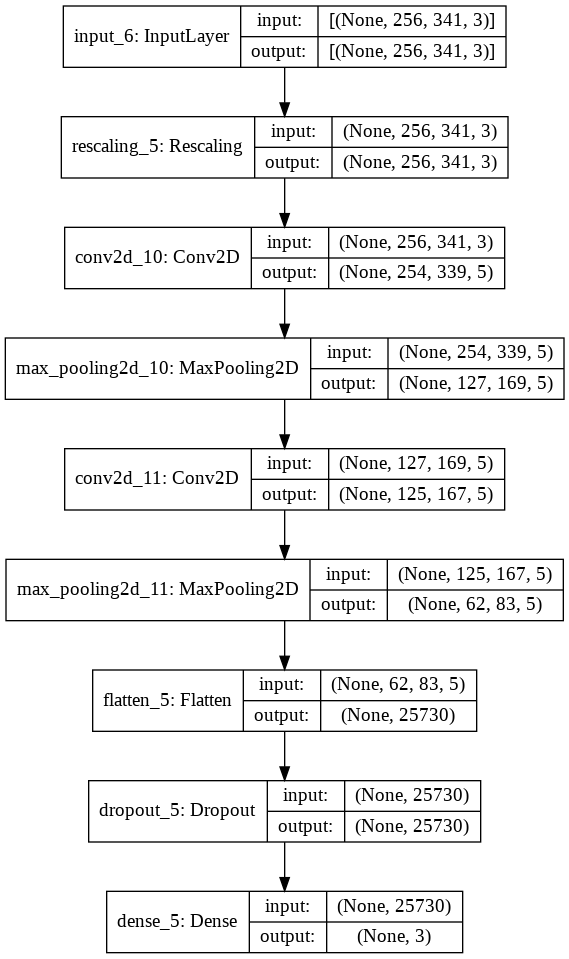

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[2:6]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

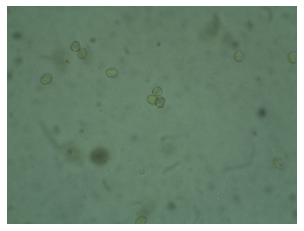

In [ ]:
num = 4
plt.imshow(X_test[num].astype("uint8"))
plt.axis("off")
plt.savefig(str(num))

In [ ]:
activations = activation_model.predict(np.expand_dims(X_test[num], axis=0))

In [ ]:
layer_names = []
for layer in model.layers[:]:
  layer_names.append(layer.name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


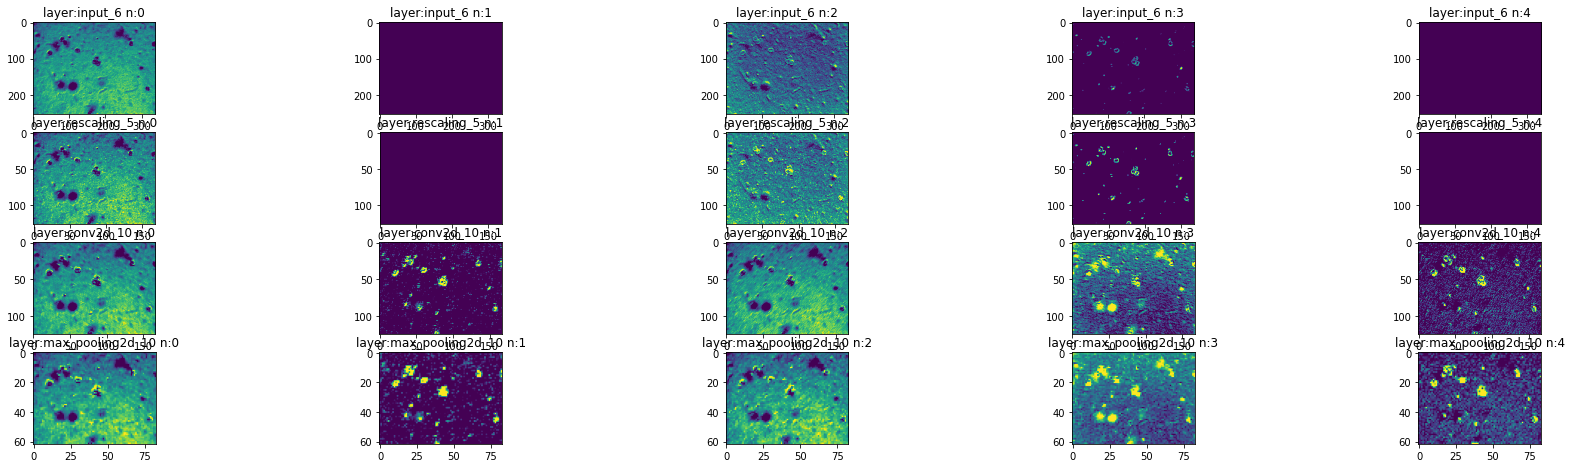

In [ ]:
plt.figure(figsize=(30, 30))
for i, layer in enumerate(activations):
  for n in range(layer.shape[3]):
    ax = plt.subplot(15, 5, i*5+n+1)
    channel_image = layer[0, :, :, n]
    channel_image -= channel_image.mean()
    channel_image /= channel_image.std()
    channel_image *= 64
    channel_image += 128
    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
    plt.imshow(channel_image.astype("uint8"))
    plt.title("layer:"+layer_names[i]+" n:"+str(n))

(254, 1695)
5.0 1.0
(125, 835)
5.0 1.0


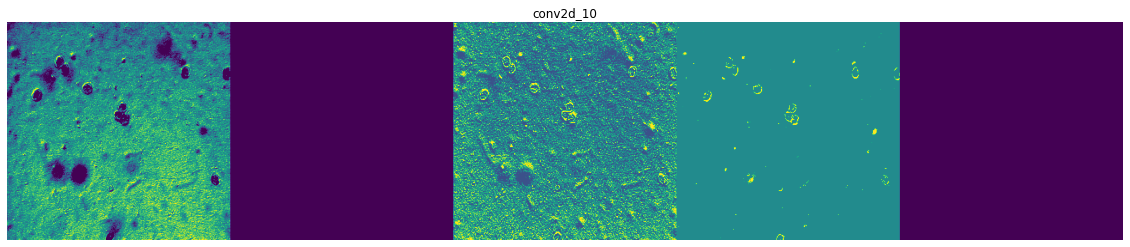

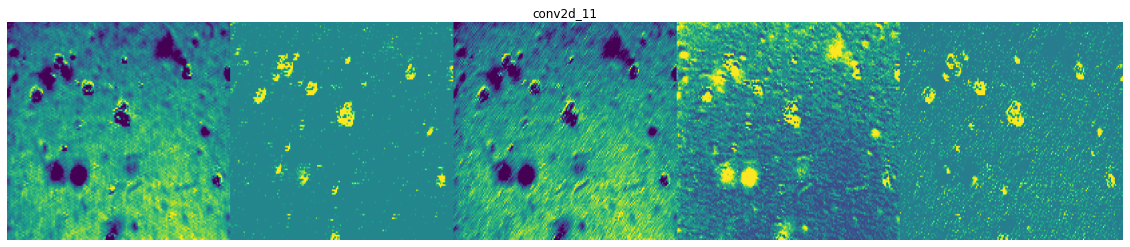

In [ ]:
layer_names = []
for layer in model.layers[:]:
  layer_names.append(layer.name)
images_per_row = 5
for layer_name, layer_activation in zip(layer_names[2:6], activations):
  if layer_name not in ["conv2d_10", "conv2d_11"]: continue
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1:3]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size[0] * n_cols, images_per_row * size[1]))
  print(display_grid.shape)
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,
                                       :, :,
                                       col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size[0] : (col + 1) * size[0],
                   row * size[1] : (row + 1) * size[1]] = channel_image
  scale_rows = 1. / size[1]
  scale_cols = 1. / size[0]
  print(scale_rows * display_grid.shape[1], scale_cols * display_grid.shape[0])
  plt.figure(figsize=(scale_rows * display_grid.shape[1]*4,
                      scale_cols * display_grid.shape[0]*4))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
  plt.axis("off")
  plt.savefig(layer_name+"="+str(num))